# Klassifikation von Hunderassen mit SVMs
Dieses Notebook nutzt zur Klassifizierung von Hunderassen eine Methode des klassischen maschinellen Lernens, die Support Vector Machine (SVM).

## 1. Laden der Daten und Aufsplitten der Daten in Trainings- und Testdaten

### Herunterladen der Daten

Bevor das Notebook ausgeführt werden kann, muss der `Images`-Ordner des [Stanford Dog Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) heruntergeladen werden und im selben Verzeichnis wie dieses Notebook im Unterordner `dataset` gesichert werden. Die resultierende Dateistruktur sollte so aussehen (Ausschnitt):
```
.
├── svm.ipynb
├── dataset
│   ├── Images
│   │   ├── n02113799-standard_poodle
│   │   ├── ...
```

Genau genommen genügen die `Images`-Unterordner

- `n02113799-standard_poodle`
- `n02113978-Mexican_hairless`
- `n02115641-dingo`
- `n02115913-dhole`
- `n02116738-African_hunting_dog`

da dies die fünf Rassen sind, die von der SVM klassifiziert werden sollen.

### Splitting

Da in jeder Klasse ausreichend Bilder zur Verfügung stehen, um Test- und Trainingsdaten bei der Kreuzvalidierung sínnvoll trennen zu können, ist dieser Vorverarbeitungsschritt prinzipiell nicht nötig. Dennoch soll an dieser Stelle gezeigt werden, wie mithilfe des eigens entwickelten Split-Helpers die Daten aufgetrennt werden.

**Hinweis:** Dieser Schritt läuft nur dann ohne Fehler, wenn die Ordner `./dataset/Train` und `./dataset/Test` noch nicht existieren. So wird sichergestellt, dass die Daten nicht mehrfach in dieselben Ordner gesplittet werden und dadurch Duplikate entstehen. Um diese Fehler zu vermeiden, kann für nachfolgende Durchläufe die Variable `SPLIT_DATA` auf `False` gesetzt werden.

In [1]:
from helpers.split import train_test_split
from helpers.train import plot_confusion_matrix

SPLIT_DATA = False  # Set True to create a data split (Make sure ./dataset/Test and ./dataset/Train directories do not exist)

if SPLIT_DATA:
    train_test_split()
    print("\n\n --- Splitting done ---")

Daneben steht im Helpers-Package auch die Funktion `load_dataset` zur Verfügung, mit der direkt aus dem `Images`-Ordner oder aus den vorbereiteten Trainings- und Test-Verzeichnissen die Bilder und zugehörigen Hunderassen eingelesen werden können. Dabei durchlaufen die Bilder eine Vorverarbeitung, in der sie auf standardmäßig 256x256 Pixel skaliert werden. Kleinere Bilder sowie die kürzeren Seiten nach der das Seitenverhältnis bewahrenden Skalierung werden schwarz aufgefüllt. Heraus kommt ein Tupel, mit den Bilddaten als `ndarray` und den Labels als `ndarray`. Für die SVM muss das Format der Labels allerdings noch angepasst werden, damit nicht mehr pro Klasse eine Komponente gesetzt wird. Standardmäßig entspricht das Label-Array vom Aufbau her nämlich der folgenden Tabelle (ohne Überschriften), die SVM erwartet allerdings einen Vektor (also 1xn statt 5xn).

| Pudel | Mexican | Dingo | Dhole | African |
|:------|:--------|:------|:------|:--------|
| 1     | 0       | 0     | 0     | 0       |
| 0     | 0       | 1     | 0     | 0       |
| 0     | 1       | 0     | 0     | 0       |
| 0     | 0       | 0     | 0     | 1       |
| 0     | 0       | 0     | 1     | 0       |

Da jedes Bild nur einer Hunderasse zugeordnet ist, die Indizes der Rassen sich nicht ändern und die einzige Spalte mit dem Maximalwert 1 jeweils die dem Bild zugeordnete Hunderasse ist, kann der Index mit dem maximalen Wert als Klassenlabel für die SVM verwendet werden.

In [2]:
from helpers.dataloader import load_dataset
import numpy as np

# load all (unsplitted) Image Data. Alternatively, change the path to use Train/Test splits
images, label_matrix = load_dataset("./dataset/Train/Images")
test_img, test_label_matrix = load_dataset("./dataset/Test/Images")

# reformat labels
labels = np.argmax(label_matrix, axis=1)
test_labels = np.argmax(test_label_matrix, axis=1)

## 2. Merkmalsextraktion

Damit die SVM trainiert werden kann, müssen aus den Bildern relevante Features extrahiert werden. Im Folgenden werden diese kurz vorgestellt.

### Körperform

Um die Körper-/Kopfform des Hundes zu bestimmen, wird eine Hough-Transformation durchgeführt. Dafür werden die durchschnittlichen Radien und die Standardabweichung der 10 signifikantesten Kreise als Features gewählt, da sie Rückschlüsse darauf erlauben, ob der Hund eher rund oder kantig ist.
Ebenfalls wird die Anzahl der Ecken als Merkmal für den Körperbau verwendet, um beispielsweise spitze oder runde Ohren besser auseinanderhalten zu können.

### Fell

Zur Erkennung, ob ein Hund Fell hat (wie ein Pudel) oder nicht (wie ein Mexican Hairless) wird ein empfindlich eingestellter Canny-Kantendetektor eingesetzt. Außerdem wird die Entropie des Bildes bestimmt, um über die "Unruhe" Rückschlüsse auf die Beschaffenheit des Fells zu ziehen.

### Farbe

Die Durchschnittsfarbe des Bilds, ein Grauwert- und ein RGB-Histogramm sollen dabei helfen, den Hund anhand der Fellfarbe zu identifizieren.

### Ergebnis

Das Modell wurde mit verschiedenen Kombinationen der Featurevektoren getestet, das beste Ergebnis basierend auf Genauigkeit und benötigter Verarbeitungszeit konnte durch die Verwendung von Grauwerthistogramm und Entropie erzielt werden. Daher sind nur diese Funktionen im Notebook enthalten. Die anderen, weniger nützlichen Featureextraktionen finden sich in `various_features.py`.

In [3]:
from skimage.measure import shannon_entropy
from skimage.color import rgb2gray


def extract_features_histogram(image, bins=32):
    image = rgb2gray(image)
    hist, _ = np.histogram(image, bins=bins, range=(0, 1))
    return hist / hist.sum()  # Normalise


def extract_image_entropy(image):
    image = rgb2gray(image)
    entropy_value = shannon_entropy(image)
    return [entropy_value]

Anhand dieser Funktionen kann nun der Merkmalsvektor für ein Bild bestimmt werden. Das Bild soll an dieser Stelle bereits als `ndarray` vorhanden sein.

In [4]:
def extract_features(image):
    fv = []
    fv.extend(extract_features_histogram(image))
    fv.extend(extract_image_entropy(image))
    return fv

Mit `extract_features` wird nun für jedes Bild der eingelesenen Daten der Merkmalsvektor berechnet. So ergibt sich aus `features` und `labels` das fertig vorbereitete Datenset für die SVM.

In [5]:
# Extract features for training
features = []
for index, image in enumerate(images):
    if index % 50 == 0:
        print("Processing training img", index)
    features.append(extract_features(image))
features = np.asarray(features)
print("---")

# Extract features for testing
test_features = []
for index, image in enumerate(test_img):
    if index % 50 == 0:
        print("Processing test img", index)
    test_features.append(extract_features(image))
test_features = np.asarray(test_features)

Processing training img 0
Processing training img 50
Processing training img 100
Processing training img 150
Processing training img 200
Processing training img 250
Processing training img 300
Processing training img 350
Processing training img 400
Processing training img 450
Processing training img 500
Processing training img 550
---
Processing test img 0
Processing test img 50
Processing test img 100
Processing test img 150


## Merkmalsreduktion und Hyperparameteroptimierung

Bei der Merkmalsreduktion werden die Verfahren PCA und LDA verglichen. Da das Training der SVM schnell geht, wird für beide Möglichkeiten eine Hyperparameteroptimierung vorgenommen und am Ende die jeweils beste Accuracy verglichen.

Dafür werden zunächst Pipelines für die beiden Möglichkeiten angelegt, jeweils mit dem StandardScaler für die Merkmalsskalierung und einer SVM. Bei der SVM wird der Random State jeweils auf denselben Wert gesetzt, um vergleichbare Ergebnisse zu erhalten. Dadurch ist der einzige Unterschied die PCA bzw. LDA. Außerdem werden die Hyperparameterraster für die Hyperparameteroptimierung mit GridSearch definiert. Diese unterscheiden sich, damit für jede Pipeline die jeweils besten Hyperparameter ermittelt werden können. Über die Aufgabenstellung hinaus wurde auch die Anzahl der

In [6]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Pipelines
pipelines = {
    'PCA': Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("svc", SVC(kernel="rbf", random_state=42))
    ]),
    'LDA': Pipeline([
        ("scaler", StandardScaler()),
        ("lda", LDA()),
        ("svc", SVC(kernel="rbf", random_state=42))
    ]),
}

# Hyperparameter-Raster
# C controls the margin tolerance of an SVM. Gamma defines the range of influence of a single data point
# in the rbf kernel.
param_grids = {
    'PCA': {
        "svc__C": [0.1, 1, 10, 100],
        "svc__gamma": [0.001, 0.01, 0.1, 1]
    },
    'LDA': {
        "svc__C": [0.1, 1, 10, 100, 200],
        "svc__gamma": [0.001, 0.01, 0.1, 1]
    },
}

Nach der Definition der grundlegenden Abläufe und Werte kann die eigentliche Hyperparameteroptimierung stattfinden. Dafür wird für jede Pipeline eine GridSearch mit 4-fold-Kreuzvalidierung durchgeführt und das beste Ergebnis zählt.

In [7]:
from sklearn.model_selection import GridSearchCV

best_estimators = {}
best_scores = {}

for method, pipeline in pipelines.items():
    print(f"\nStart training with {method} and hyperparameter optimisation...")
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[method],
        scoring="accuracy",
        cv=4,  # 4-Fold Cross Validation
        verbose=1,
        n_jobs=-1,  # Parallelise the processing of the folds
    )
    grid_search.fit(features, labels)
    best_estimators[method] = grid_search.best_estimator_
    best_scores[method] = grid_search.best_score_

    print(f"\nBest parameters for {method}: {grid_search.best_params_}")
    print(f"Best Cross Validation Avg Accuracy for {method}: {grid_search.best_score_:.4f}")


Start training with PCA and hyperparameter optimisation...
Fitting 4 folds for each of 16 candidates, totalling 64 fits

Best parameters for PCA: {'svc__C': 10, 'svc__gamma': 0.01}
Best Cross Validation Avg Accuracy for PCA: 0.3768

Start training with LDA and hyperparameter optimisation...
Fitting 4 folds for each of 20 candidates, totalling 80 fits

Best parameters for LDA: {'svc__C': 1, 'svc__gamma': 0.1}
Best Cross Validation Avg Accuracy for LDA: 0.2911


Das Ergebnis der Analyse zeigt, dass die PCA besser abschneidet. Der optimale Hyperparameter $C = 1$ weist darauf hin, dass die SVM versucht, eine "weiche" Trennlinie zwischen den Klassen zu ziehen - das ist aufgrund der schwierigen Trennbarkeit der Daten ein gutes Zeichen. Das moderat gewählte $\gamma = 0.1$ ermöglicht es der SVM, auf Details einzugehen, ohne zu sehr ins Overfitting zu kommen.

Das auf diese Weise gefundene beste Modell wird nun als optimiertes Modell weiterverwendet und einer finalen Kreuzvalidierung unterzogen (die dasselbe Ergebnis haben wird wie zuvor, sofern immer noch 4 folds verwendet werden), um konkrete Werte für den Vergleich mit dem als nächstes implementierten k-Nearest-Neighbour-Klassifikator zu erhalten.

In [8]:
from sklearn.model_selection import cross_val_score

optimised_model = best_estimators['PCA']

cv_scores = cross_val_score(optimised_model, features, labels, cv=4, scoring="accuracy")

print("\nResults of the Cross Validation:")
for fold_index, score in enumerate(cv_scores, 1):
    print(f"Fold {fold_index}: Accuracy = {score:.4f}")

print(
    f"\nAverage Accuracy over all folds: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}"
)


Results of the Cross Validation:
Fold 1: Accuracy = 0.3714
Fold 2: Accuracy = 0.4143
Fold 3: Accuracy = 0.3286
Fold 4: Accuracy = 0.3929

Average Accuracy over all folds: 0.3768 ± 0.0317


Accuracy of the SVM when tested again Validation (Test) Dataset 0.43157894736842106
Train Images: 560,	Accuracy: 45.8929%
Test Images: 190,	Accuracy: 43.1579%


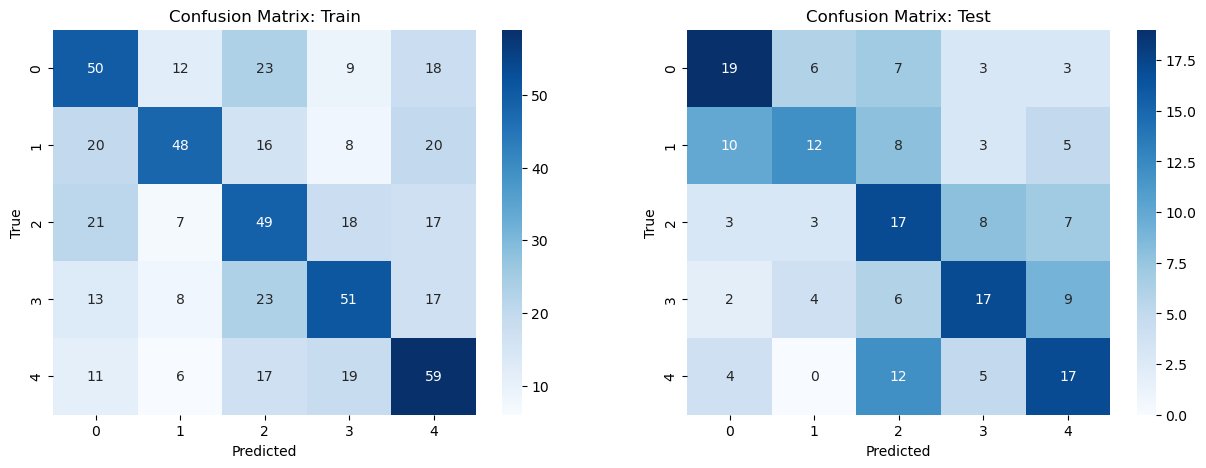

In [9]:
prediction = optimised_model.predict(test_features)

accuracy = np.sum(prediction == test_labels) / len(test_labels)
print("Accuracy of the SVM when tested again Validation (Test) Dataset", accuracy)

plot_confusion_matrix(model=optimised_model, x_train=features, y_train=labels, x_test=test_features, y_test=test_labels,)

Die Konfusionsmatrizen zeigen, dass die SVM die Daten nur schwer trennen kann. Dieses Ergebnis war zu erwarten, da die Klassen verschwimmen und große Überlappungen haben, die von der SVM nicht sinnvoll abgegrenzt werden können, ohne ins Overfitting zu geraten. Das Ergebnis zeigt, dass ein sinnvoller Kompromiss zwischen Accuracy und Overfitting gefunden wurde, da das Klassifikationsergebnis der Testdaten akzeptabel ist und die Genauigkeit auf den Trainingsdaten nicht an Perfektion grenzt (was auf Overfitting hindeuten würde).

## Implementierung des k-nearest-Neighbour-Klassifikators

Zunächst wird der Klassifikator instanziiert und -- wie auch bei der SVM -- die Grid Search für die Hyperparameteroptimierung vorbereitet.
Danach wird der Klassifikator mit den besten Parametern erneut kreuzvalidiert, um finale Ergebnisse für den Vergleich zu erhalten. Insgesamt ist der Prozess damit sehr ähnlich zur Erstellung und Hyperparameteroptimierung der SVM.

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(metric="manhattan", weights="distance", n_jobs=-1)
param_grid_knn = {
    "n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15],
}

# Hyperparameter Optimisation
print("\nStart training with k-NN and hyperparameter optimisation...")
grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    scoring="accuracy",
    cv=4,  # 4-Fold Cross Validation
    verbose=1,
    n_jobs=-1,  # Parallelise processing
)
grid_search_knn.fit(features, labels)

# Save the best model, parameters and values
best_knn_model = grid_search_knn.best_estimator_
best_knn_params = grid_search_knn.best_params_
best_knn_score = grid_search_knn.best_score_

# Print results of optimisation
print(f"\nBest parameters for k-NN: {best_knn_params}")
print(f"Best Cross Validation Avg Accuracy for k-NN: {best_knn_score:.4f}")


Start training with k-NN and hyperparameter optimisation...
Fitting 4 folds for each of 8 candidates, totalling 32 fits

Best parameters for k-NN: {'n_neighbors': 3}
Best Cross Validation Avg Accuracy for k-NN: 0.3625


Wie bereits bei der Hyperparameteroptimierung der SVM hat sich auch beim k-Nearest-Neighbour-Klassifikator ein moderater Wert als optimal herausgestellt: Mit $k = 13$ werden genügend Nachbarn miteinbezogen, um ausreichende Stabilität gegen Ausreißer zu bieten, ohne stark zu Overfitting zu neigen.

In [11]:
# Validate final model again (no different results expected than before when using 4 folds)
cv_scores_knn = cross_val_score(
    best_knn_model, features, labels, cv=4, scoring="accuracy"
)

print("\nResults of the Cross Validation for k-NN:")
for fold_index, score in enumerate(cv_scores_knn, 1):
    print(f"Fold {fold_index}: Accuracy = {score:.4f}")

print(
    f"\nAverage Accuracy over all folds: {cv_scores_knn.mean():.4f} ± {cv_scores_knn.std():.4f}"
)


Results of the Cross Validation for k-NN:
Fold 1: Accuracy = 0.3571
Fold 2: Accuracy = 0.3500
Fold 3: Accuracy = 0.3714
Fold 4: Accuracy = 0.3714

Average Accuracy over all folds: 0.3625 ± 0.0093


Accuracy of the SVM when tested again Validation (Test) Dataset 0.35789473684210527
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Train Images: 560,	Accuracy: 100.0000%
Test Images: 190,	Accuracy: 35.7895%


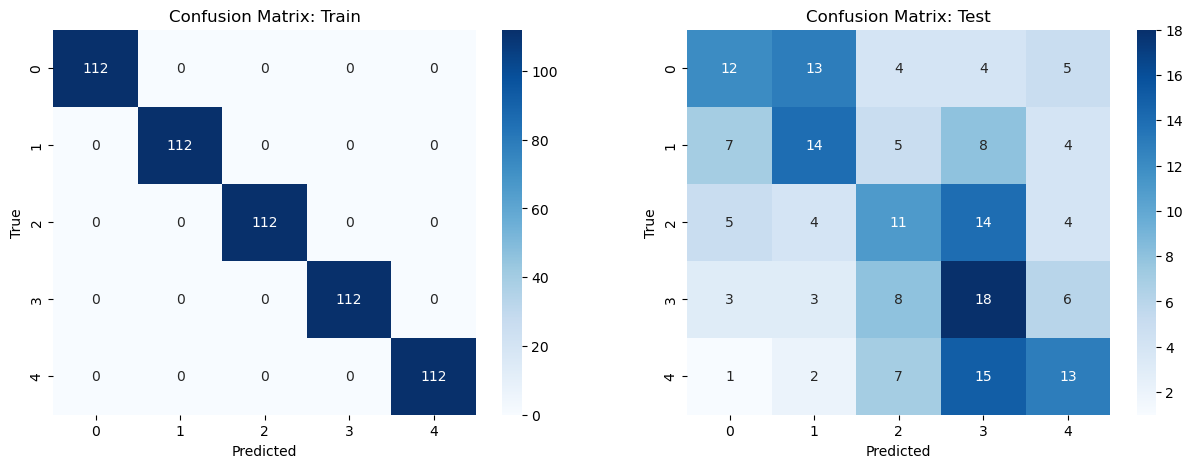

In [12]:
knn_prediction = best_knn_model.predict(test_features)

knn_accuracy = np.sum(knn_prediction == test_labels) / len(test_labels)
print("Accuracy of the SVM when tested again Validation (Test) Dataset", knn_accuracy)

print(type(best_knn_model))
plot_confusion_matrix(model=best_knn_model, x_train=features, y_train=labels, x_test=test_features, y_test=test_labels,)

Die Klassifikationsgenauigkeit beim Training liegt beim k-Nearest-Neighbour-Klassifikator bei 100 %. Bei anderen Modellen deutet dies auf starkes Overfitting hin, allerdings ist die perfekte Genauigkeit bei k-NN nicht bedenklich. Das liegt daran, dass das Modell die Trainingsdatenpunkte direkt speichert und Klassifikationsdaten anhand ihrer Nähe zu Trainingsdaten einordnet. Da die Trainingsdaten jeweils zu sich selbst den minimalen Abstand haben, ist eine perfekte Klassifikation sogar zu erwarten.

Die Konfusionsmatrix über die Testdaten zeigt hingegen, dass der Klassifikator sich bei der Klassifikation sehr unsicher ist. Das liegt daran, dass die Eingabedaten (Hunderassen) nicht scharf trennbar sind und große Überlappungen zwischen den Klassen auftreten. Durch die Betrachtung der nahen Punkte kommt es dann in den Überlappungen zu häufigen Fehlklassifikationen.

## Vergleich der Ergebnisse von SVM und k-NN-Klassifikator

Die SVM schneidet in der 4-fold-Kreuzvalidierung nach der Hyperparameteroptimierung mit einer durchschnittlichen Genauigkeit von 43,1 % etwas besser ab als der k-Nearest-Neighbour-Klassifikator (35,8 %). Beide Genauigkeiten sind eher schlecht, was daran liegt, dass die Eingabedaten nur schwer trennbar sind und Klassen sich häufig und stark überlappen. Das kann an den Konfusionsmatrizen erkannt werden. Das etwas bessere Abschneiden der SVM kann dadurch erklärt werden, dass die Abgrenzung der Klassen durch einen Support Vector durch die Überlappungsgebiete besser funktioniert (SVM) als nur die direkte Umgebung eines Punktes zu prüfen (k-NN), da einzelne Punktanhäufungen das SVM-Ergebnis weniger verzerren als das von k-Nearest-Neighbours.